# Hists Hists Hists ...

This notebook 
- loads pandas dataframes to plot 1d-hists
- loads hists objects to plot stacked 1d-hists

In [263]:
import argparse
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

import hist as hist2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## 1d-Hists from pandas dataframes

In [260]:
data = {}
data['ele'] = pd.read_csv('extra/data_ele_gen_Hpt.csv')
data['mu'] = pd.read_csv('extra/data_mu_gen_Hpt.csv')

In [261]:
data['ele'].keys()

Index(['Unnamed: 0', 'gen_Hpt', 'sample', 'weight'], dtype='object')

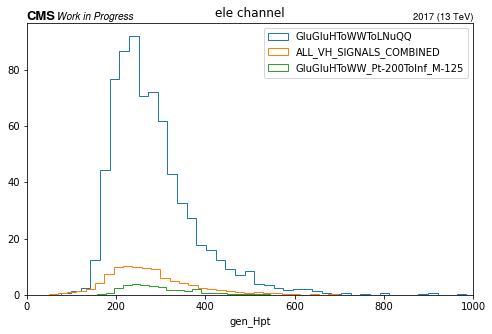

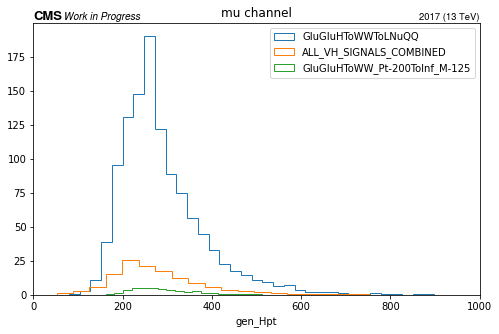

In [262]:
channels = ['ele', 'mu']
for ch in channels:
    fig, ax = plt.subplots(figsize=(8, 5))

    # make plots per channel
    for sample in data[ch]['sample'].unique():
        if 'VBFHToWWToLNuQQ-MH125' not in sample:
            plt.hist(data[ch]['gen_Hpt'][data[ch]['sample']==sample], 
                     bins=50, 
                     label=sample, 
#                      density=True,
                     histtype='step',
                     weights=data[ch]['weight'][data[ch]['sample']==sample])

    ax.legend()
    ax.set_xlabel(f"gen_Hpt")
    ax.set_title(f'{ch} channel')
    ax.set_xlim(0,1000)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax);
    plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_gen_HpTplots.pdf')
    # plt.close()
#     break

## Stacked-Hists from hists objects

In [370]:
signal_labels

['GluGluHToWWToLNuQQ',
 'ttHToNonbb_M125',
 'ALL_VH_SIGNALS_COMBINED',
 'GluGluHToWW_Pt-200ToInf_M-125']

In [376]:
# utils.py stuff

simplified_labels = {
  "GluGluHToWWToLNuQQ": "ggH-LNuQQ",
  "ttHToNonbb_M125": "ttH",
  "GluGluHToWW_Pt-200ToInf_M-125": "ggH-Pt200",
  "ALL_VH_SIGNALS_COMBINED": "VH",
  "VBFHToWWToLNuQQ-MH125": "VBF-LNuQQ",
}

# define the axes for the different variables to be plotted
# define samples
signal_by_ch = {
    'ele': ['GluGluHToWWToLNuQQ', 'ttHToNonbb_M125', 'GluGluHToWW_Pt-200ToInf_M-125', 'ALL_VH_SIGNALS_COMBINED', 'VBFHToWWToLNuQQ-MH125'],
    'mu': ['GluGluHToWWToLNuQQ', 'ttHToNonbb_M125', 'GluGluHToWW_Pt-200ToInf_M-125', 'ALL_VH_SIGNALS_COMBINED', 'VBFHToWWToLNuQQ-MH125'],
    'had': ['ggHToWWTo4Q-MH125'],
}


# there are many signal samples for the moment:
# - ele,mu: GluGluHToWWToLNuQQ
# - had: 
#   - ggHToWWTo4Q-MH125 (produced by Cristina from PKU config files Powheg+JHU) - same xsec as GluGluToHToWWTo4q
#   - GluGluToHToWWTo4q (produced by PKU) 
#   - GluGluHToWWTo4q (produced by Cristina w Pythia)
#   - GluGluHToWWTo4q-HpT190 (produced by Cristina w Pythia)
# to come: GluGluHToWW_MINLO (for ele,mu,had)

data_by_ch = {
    'ele': 'SingleElectron',
    'mu': 'SingleMuon',
    'had': 'JetHT',
}
data_by_ch_2018 = {
    'ele': 'EGamma',
    'mu': 'SingleMuon',
    'had': 'JetHT',
}
color_by_sample = {
    "QCD": 'tab:orange',
    "DYJets": 'tab:purple',
    "WJetsLNu": 'tab:green',
    "TTbar": 'tab:blue',
    "ZQQ": 'tab:pink',
    "WQQ": 'tab:red',
    "SingleTop": 'tab:cyan',
    "GluGluHToWWToLNuQQ": 'tab:red',
    "ttHToNonbb_M125": 'tab:olive',
    "GluGluHToWW_Pt-200ToInf_M-125": "tab:orange",
    "ALL_VH_SIGNALS_COMBINED": "tab:brown",
    "VBFHToWWToLNuQQ-MH125": "tab:gray",
}
    
# available tab colors
# 'tab:cyan'
# 'tab:olive'
# 'tab:gray'
# 'tab:brown':

add_samples = {
    'SingleElectron': 'SingleElectron',
    'EGamma': 'EGamma',
    'SingleMuon': 'SingleMuon',
    'JetHT': 'JetHT',
    'QCD': 'QCD_Pt',
    'DYJets': 'DYJets',
    'ZQQ': 'ZJetsToQQ',
    'WQQ': 'WJetsToQQ',
    'SingleTop': 'ST',
    'TTbar': 'TT',
    'WJetsLNu': 'WJetsToLNu',
    'GluGluHToWWTo4q': 'GluGluHToWWTo4q',
}

label_by_ch = {
    'ele': 'Electron',
    'mu': 'Muon',
    'had': 'Hadronic',
}

In [377]:
with open(f'hists_2017/stacked_hists/ele_hists.pkl', 'rb') as f:
    hists = pkl.load(f)
    f.close()

In [319]:
hists['fj_pt']

Hist(
  StrCategory(['GluGluHToWWToLNuQQ', 'SingleElectron', 'DYJets', 'QCD', 'ttHToNonbb_M125', 'ALL_VH_SIGNALS_COMBINED', 'GluGluHToWW_Pt-200ToInf_M-125', 'VBFHToWWToLNuQQ-MH125', 'TTbar', 'SingleTop', 'WJetsLNu'], growth=True, name='samples', label='samples'),
  Regular(40, 200, 1000, name='var', label='Jet $p_T$ [GeV]'),
  storage=Double()) # Sum: 189796.32758344838 (190136.0248813751 with flow)

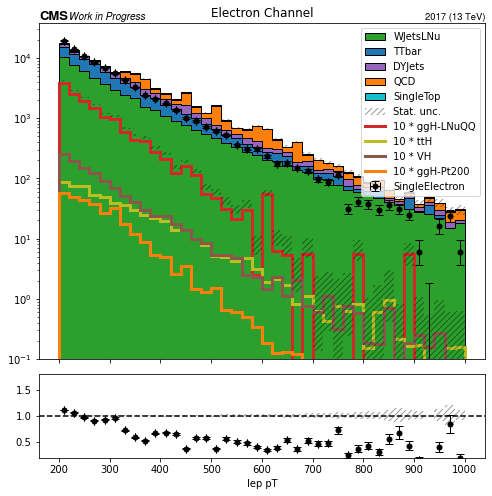

In [388]:
ch = 'ele'
year = '2017'
vars_to_plot = {'ele': ['fj_pt']}

data_label = data_by_ch[ch]
if year == '2018':
    data_label = data_by_ch_2018[ch]
elif year == 'Run2':
    data_label = 'Data'

for var in vars_to_plot[ch]:
    # get histograms
    h = hists[var]

    if h.shape[0] == 0:     # skip empty histograms (such as lepton_pt for hadronic channel)
        print('Empty histogram ', var)
        continue

    # get samples existing in histogram
    samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]

if None in samples:
    samples = samples[:-1]    
    
    
add_data = True

signal_labels = [label for label in samples if label in signal_by_ch[ch]]
bkg_labels = [label for label in samples if (label and label != data_label and label not in signal_labels)]
if 'VBFHToWWToLNuQQ-MH125' in signal_labels:
    signal_labels.remove('VBFHToWWToLNuQQ-MH125')

# data
data = None
if data_label in h.axes[0]:
    data = h[{"samples": data_label}]
    
# signal
signal = [h[{"samples": label}] for label in signal_labels]
signal = [s * 10 for s in signal]  # if not log, scale the signal

# background
bkg = [h[{"samples": label}] for label in bkg_labels]

if add_data and data and len(bkg) > 0:
    fig, (ax, rax) = plt.subplots(nrows=2,
                                  ncols=1,
                                  figsize=(8, 8),
                                  gridspec_kw={"height_ratios": (4, 1), 'hspace': 0.07},
                                  sharex=True
                                  )
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    rax = None

errps = {
    'hatch': '////',
    'facecolor': 'none',
    'lw': 0,
    'color': 'k',
    'edgecolor': (0, 0, 0, .5),
    'linewidth': 0,
    'alpha': 0.4
}
if len(bkg) > 0:
    hep.histplot(bkg,
                 ax=ax,
                 stack=True,
                 sort='yield_r',
                 edgecolor='black',
                 linewidth= 1,
                 histtype="fill",
                 label=[bkg_label for bkg_label in bkg_labels],
                 color = [color_by_sample[bkg_label] for bkg_label in bkg_labels]
                 )
#     for handle, label in zip(*ax.get_legend_handles_labels()):
#         handle.set_color(color_by_sample[label])

    tot = bkg[0].copy()
    for i, b in enumerate(bkg):
        if i > 0:
            tot = tot + b
    ax.stairs(
        values=tot.values() + np.sqrt(tot.values()),
        baseline=tot.values() - np.sqrt(tot.values()),
        edges=tot.axes[0].edges, **errps,
        label='Stat. unc.'
    )

if add_data and data:
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'elinewidth': 1,
    }
    hep.histplot(data,
                 ax=ax,
                 histtype="errorbar",
                 color="k",
                 capsize=4,
                 yerr=True,
                 label=data_label,
                 **data_err_opts
                 )

    if len(bkg) > 0:
        from hist.intervals import ratio_uncertainty
        yerr = ratio_uncertainty(data.values(), tot.values(), 'poisson')
        rax.stairs(1 + yerr[1], edges=tot.axes[0].edges, baseline=1 - yerr[0], **errps)

        if ak.all(tot.values()) > 0:
            hep.histplot(data.values() / tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values()) / tot.values(),
                         ax=rax, histtype='errorbar', color='k', capsize=4)
        else:
            print(f'Warning: no all bins filled for background histogram for {var} {ch}')
        rax.axhline(1, ls='--', color='k')
        rax.set_ylim(0.2, 1.8)
        # rax.set_ylim(0.7, 1.3)

if len(signal) > 0:
    sigg = None
    for i, sig in enumerate(signal):
        hep.histplot(sig,
                     ax=ax,
                     label = f'10 * {simplified_labels[signal_labels[i]]}',
                     linewidth= 3,
                     color = color_by_sample[signal_labels[i]]
                     )
        if sigg == None:
            sigg = signal[i].copy()
        else:
            sigg = sigg + sig
    ax.stairs(
        values=sigg.values() + np.sqrt(sigg.values()),
        baseline=sigg.values() - np.sqrt(sigg.values()),
        edges=sig.axes[0].edges, **errps,
    )

if rax!=None:
    ax.set_xlabel("")
    rax.set_xlabel('lep pT')

ax.set_yscale('log')
ax.set_ylim(0.1)
ax.set_title(f'{label_by_ch[ch]} Channel')
ax.legend()

hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_hist_plot.pdf')